# Trajectory Generator

This notebook contains the basic code required to transform waypoint information from resolution advisories into trajectory curves to follow.

In [1]:
type Waypoint
    lat     :: Float64  # [dec deg] latitude
    lon     :: Float64  # [dec deg] longitude
    alt     :: Float64  # [ft AGL] altitude
    speed   :: Float64  # [ft/s] speed
    head    :: Float64  # [deg] heading
    period  :: Float64  # [s] period to hold maneuver parameters
    turn    :: Float64  # [deg/s] turn rate
end # type

typealias Advisory Vector{Waypoint}

Array{Waypoint,1}

In [2]:
function latlon2xy(lat::Float64, lon::Float64)
    # converts lat lon measurements from decimal degrees to ft
    x = lat * (10000 / 90) * 3280.4  # [ft] East is positive
    y = lon * (10000 / 90) * 3280.4  # [ft] North is positive
    return [x, y]
end # function latlon2xy

latlon2xy (generic function with 1 method)

In [3]:
function state_update!(wp::Waypoint, dt::Float64)
    if wp.turn != 0
        turn_radius = abs(wp.speed / deg2rad(wp.turn))
        turn_amount = deg2rad(wp.turn) * dt
        
        wp.lat += turn_radius * sign(turn_amount) * 
                  (sin(deg2rad(wp.head)) - sin(deg2rad(wp.head) - turn_amount))
        wp.lon += turn_radius * sign(turn_amount) * 
                  (-cos(deg2rad(wp.head)) + cos(deg2rad(wp.head) - turn_amount))
        wp.head += rad2deg(turn_amount)
    else
        wp.lat += wp.speed * dt * cos(deg2rad(wp.head))
        wp.lon += wp.speed * dt * sin(deg2rad(wp.head))
    end # if
end # function state_update!

state_update! (generic function with 1 method)

## Trajectory

Each point in the trajectory contains 3 variables: the latitude and longitude in ft, and the speed in ft/s.

In [4]:
function initialize_trajectory(adv::Advisory, dt::Float64)
    time_steps = int(sum([wp.period / dt + 1 for wp in adv]))
    traj = zeros(4, time_steps)
    return traj
end # function initialize_trajectory


function update_trajectory!(traj::Array{Float64, 2}, counter::Int64, wp::Waypoint)
    traj[1, counter] = wp.lat
    traj[2, counter] = wp.lon
    traj[3, counter] = wp.speed
    traj[4, counter] = wp.head
end # function update_trajectory!


function trajectory_generator(adv::Advisory, dt::Float64)
    traj = initialize_trajectory(adv, dt)
    wp_curr = Waypoint(0., 0., 0., 0., 0., 0., 0.)
    counter = 1
    
    for i = 1:length(adv)
        wp_curr = deepcopy(adv[i])
        update_trajectory!(traj, counter, wp_curr)
        counter += 1
        
        for j = 1:adv[i].period / dt
            state_update!(wp_curr, dt)
            update_trajectory!(traj, counter, wp_curr)
            counter += 1
        end # for j
    end # for i
    
    return traj
end # function trajectory_generator

trajectory_generator (generic function with 1 method)

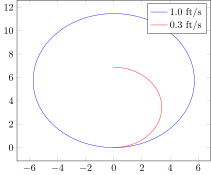

In [5]:
using PGFPlots
DT = 0.1
adv = [Waypoint(0.,0.,1.,1.,1.,36.,10.), Waypoint(0.,0.,1.,0.3,1.,36.,5.)]
traj = trajectory_generator(adv, DT)
Axis([
    Plots.Linear(vec(traj[1,1:adv[1].period/DT + 1]), vec(traj[2,1:adv[1].period/DT + 1]), 
                 style="mark=", legendentry=string(adv[1].speed, " ft/s")),
    Plots.Linear(vec(traj[1,adv[1].period/DT + 2:end]), vec(traj[2,adv[1].period/DT + 2:end]),
                 style="mark=", legendentry=string(adv[2].speed, " ft/s"))]
)